In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

# 1. Time Series Task

In [30]:
long = pd.read_csv('patient_longitudinal.csv', sep = '\t')

### 1. Convert the longitudinal blood pressure measurements into a proper time series:

The patient_longitudinal.csv data is first converted to the correct datetime format and cleaned. No duplicate rows or NA values were found in this data.

In [ ]:
# change the visit dates to datetime format
long['visit_date'] = pd.to_datetime(long['visit_date'], format='%Y-%m-%d')

# find duplicate rows
dupes = long.duplicated(keep='first')
if dupes.any():
    print("Duplicate rows:")
    print(long[dupes]) # no duplicates found

# order dataframe by date
long.set_index('visit_date', inplace=True)
long.sort_index(inplace=True)

# check for NA values
print(long.isna().sum()) # no NA values found


### 2. Analyze blood pressure trends:

The monthly means, 3-month moving averages, and exponential weighted averages are calculated below. Gaps in the dates are interpolated as well. 

In [ ]:
# month-end frequency
month_mean = long.resample('ME').mean()

# 3 month moving averages
month_mean['bp_moving_avg'] = month_mean['bp_systolic'].rolling(window=3, min_periods=1).mean()

# interpolating gaps
month_mean['bp_systolic'] = month_mean['bp_systolic'].interpolate(method='linear')

# exponential weighted alternatives
month_mean['bp_systolic_ewm'] = month_mean['bp_systolic'].ewm(span=3).mean()

Plot of the trend of blood pressure:

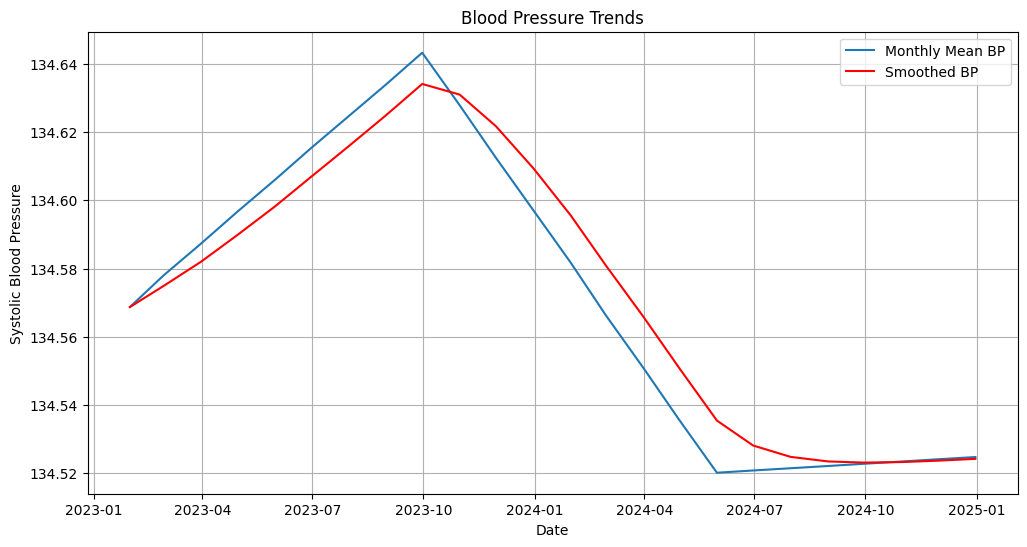

In [50]:
plt.figure(figsize=(12, 6))

# Original monthly means
plt.plot(month_mean.index, month_mean['bp_systolic'], label='Monthly Mean BP')

# Exponential weighted moving average
plt.plot(month_mean.index, month_mean['bp_systolic_ewm'], label='Smoothed BP', color='red')

plt.title('Blood Pressure Trends')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure')
plt.legend()
plt.grid()

plt.show()

# Statistical Modeling Tasks

### 1. Analyze factors affecting baseline blood pressure:

The follow code creates a model to predict systolic blood pressure using the variables age, sex, smoking, and diabetes with robust standard errors. 

In [55]:
X = long[['age', 'sex', 'smoking', 'diabetes']] # setting predictor variables
y = long[['bp_systolic']] # setting outcome variable

X = sm.add_constant(X)

# creating the model with robust standard error covariance
model = sm.OLS(y, X).fit(cov_type='HC3')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     505.2
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:45:01   Log-Likelihood:                -15128.
No. Observations:                4000   AIC:                         3.027e+04
Df Residuals:                    3995   BIC:                         3.030e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        115.5937      0.629    183.694      0.0

Based on the model, smoking and diabetes have a strong positive association with systolic blood pressure and age has a weak positive association with blood pressure. Each of these predictor variables has a p-value of approximately 0.00 indicating smoking, diabetes, and age are all significant predictors of systolic blood pressure.

According to the coefficients, sex has a weak negative association with blood pressure and a p-value of 0.099 indicating there is no significant association between sex and blood pressure. 

The model has a r-squared value of 0.329 indicating a moderately poor fit to the data. 

Diagnostic Plots:

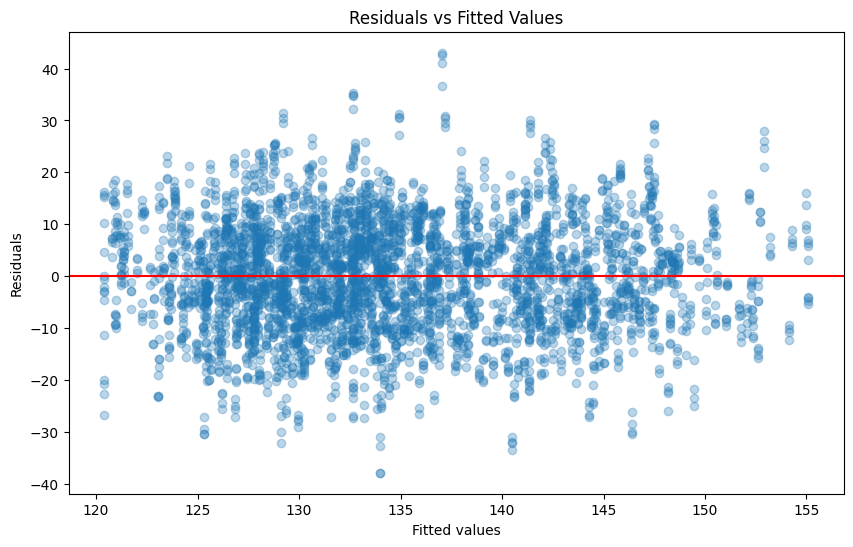

In [61]:
# Residuals vs Fitted Plot
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid, alpha=0.3)
plt.axhline(y=0, color = "red")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")

plt.show()

<Figure size 1000x600 with 0 Axes>

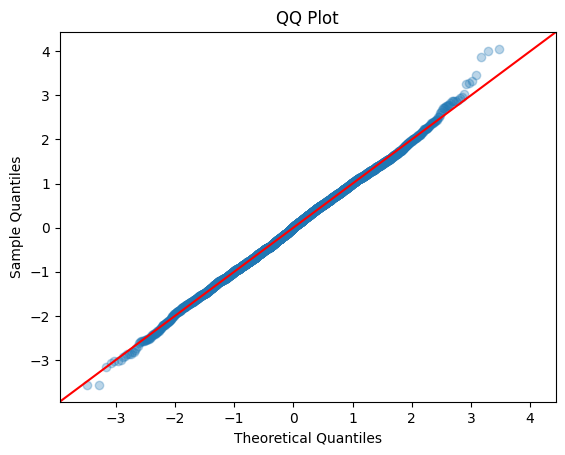

In [66]:
# qq plot
plt.figure(figsize=(10, 6))
sm.qqplot(model.resid, line='45', fit=True, alpha=0.3)
plt.title("QQ Plot")

plt.show()

The residuals vs fitted plot appears approximately random with no apparent patterns. The QQ plot also looks approximately normal with no extreme deviations. 

### 2. Model treatment effectiveness:

In [85]:
# reading in patient_baseline.csv and patient_treatment.csv
base = pd.read_csv('patient_baseline.csv', sep = '\t')
treat = pd.read_csv('patient_treatment.csv', sep = '\t')

# selecting columns to merge
base_cols = base[['patient_id', 'age', 'sex', 'bmi', 'smoking', 'diabetes', 'bp_systolic', 'cholesterol', 'heart_rate']]
treat_cols = treat[['patient_id', 'treatment', 'adherence', 'outcome']]

merged_data = pd.merge(base_cols, treat_cols, on="patient_id", how="inner")


The follow code creates a GLM model to predict treatment success using baseline characteristics:

In [83]:
X = merged_data[['adherence', 'age', 'sex', 'bmi', 'smoking', 'diabetes' ,'bp_systolic', 'cholesterol', 'heart_rate']] # setting predictor variables
y = merged_data[['outcome']] # setting outcome variable

X = sm.add_constant(X)

# creating the GLM model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

# odds ratios
odds_ratios = np.exp(model.params)
conf = model.conf_int()
conf_odds_ratios = np.exp(conf)

print("Odds Ratios:")
print(odds_ratios)
print("95% Confidence Intervals:")
print(conf_odds_ratios)


Odds Ratios:
const          0.013070
adherence      7.404862
age            1.001881
sex            0.925642
bmi            0.992188
smoking        0.768155
diabetes       0.572442
bp_systolic    1.017250
cholesterol    1.006231
heart_rate     0.990072
dtype: float64
95% Confidence Intervals:
                    0          1
const        0.001121   0.152422
adherence    1.978332  27.716269
age          0.991077   1.012804
sex          0.711743   1.203824
bmi          0.964346   1.020834
smoking      0.500439   1.179089
diabetes     0.395157   0.829265
bp_systolic  1.003693   1.030990
cholesterol  0.999717   1.012787
heart_rate   0.977849   1.002448


In [84]:
# print deviance
print(f"Null Deviance: {model.null_deviance}")
print(f"Residual Deviance: {model.deviance}")

Null Deviance: 1334.774434101428
Residual Deviance: 1284.4462321365681


The residual deviance is lower than the null deviance indicating that some of the variance is being explained by the model. However, more information is needed to determine if this is a signficanta reduction in deviation. 

Cook's Distance Plot:

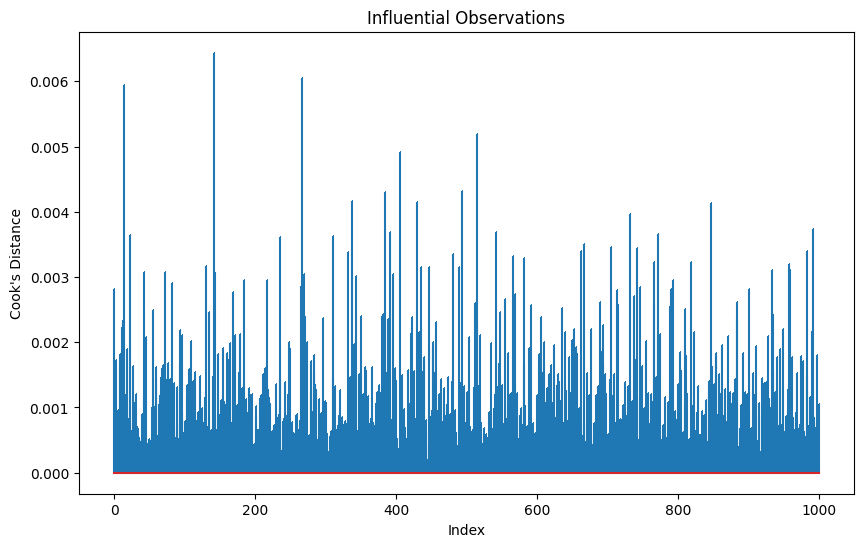

In [90]:
# influential points
influence = model.get_influence()
cooks = influence.cooks_distance[0] 

# cook's distance plot
plt.figure(figsize=(10, 6))
plt.stem(cooks, markerfmt=",")
plt.xlabel("Index")
plt.ylabel("Cook's Distance")
plt.title("Influential Observations")
plt.show()

Based on the plot, there are no significant influential points as all of the observations have a low Cook's Distance value. Therefore, the model explains the data well as there are no extreme points.

# Machine Learning Tasks

### 1. Build a prediction pipeline:

In [95]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

In [100]:
X = merged_data[['adherence', 'age', 'sex', 'bmi', 'smoking', 'diabetes' ,'bp_systolic', 'cholesterol', 'heart_rate']] # setting predictor variables
y = merged_data[['outcome']] # setting outcome variable

In [113]:
numeric_features = ['age', 'bmi', 'adherence','bp_systolic', 'cholesterol', 'heart_rate']
numeric_transformer = StandardScaler()

# Create pipeline with specific components
pipeline = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_classif, k='all'),  # feature selection
    LogisticRegression(
        penalty='l2',  
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'  
    )
)

### 2. Validate model performance:

In [114]:
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold,
    cross_validate
)
from sklearn.metrics import (
    classification_report,
    RocCurveDisplay,
    confusion_matrix,
    roc_auc_score
)


In [119]:
# Stratified split for imbalanced data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y,
    random_state=42
)

# Cross-validation with multiple metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)


/home/m1/scripts/08-time-stats-and-ml-mtsen1/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/m1/scripts/08-time-stats-and-ml-mtsen1/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/m1/scripts/08-time-stats-and-ml-mtsen1/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/m1/scripts/08-time-stats-and-ml-mtsen1/.venv/lib/python3.10/site-packages/sklearn/uti

In [120]:
# fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# redict on the test set
y_pred = pipeline.predict(X_test)

/home/m1/scripts/08-time-stats-and-ml-mtsen1/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/m1/scripts/08-time-stats-and-ml-mtsen1/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The follow code generates the confusion matrix and the accuracy, precision, and recall:

In [121]:
# confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[91 93]
 [49 67]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.49      0.56       184
           1       0.42      0.58      0.49       116

    accuracy                           0.53       300
   macro avg       0.53      0.54      0.52       300
weighted avg       0.56      0.53      0.53       300



The following code calculate the AUC and plots the ROC curve:

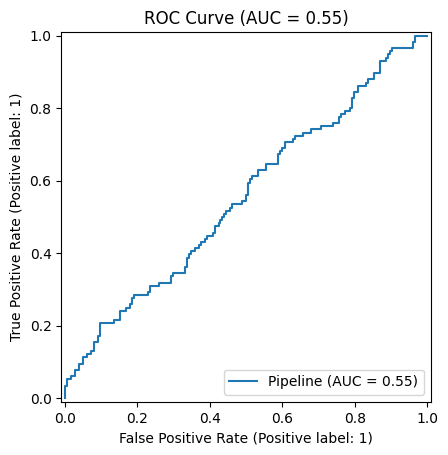

In [122]:
# ROC AUC
y_prob = pipeline.predict_proba(X_test)[:, 1] 
roc_auc = roc_auc_score(y_test, y_prob)

# ROC plot
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
plt.show()
